<a href="https://colab.research.google.com/github/Victor1992/Bit_Predict_Regression/blob/main/bit_predict_time_series_forecasting_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series forecating funcdamentals with tensorflow : Bit Predict

## Importing time series data with pandas



In [30]:
import pandas as pd



In [31]:
df = pd.read_csv("/content/sample_data/BTC_USD_2014-11-04_2022-01-10-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-11-04,BTC,324.467934,323.826186,333.539527,323.106623
2014-11-05,BTC,328.644408,324.424164,330.671610,320.902900
2014-11-06,BTC,337.921358,328.653046,342.384170,328.597125
2014-11-07,BTC,348.992860,337.921358,352.585895,336.236830
2014-11-08,BTC,341.459753,348.992860,351.651854,340.196145


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2625 entries, 2014-11-04 to 2022-01-10
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2625 non-null   object 
 1   Closing Price (USD)  2625 non-null   float64
 2   24h Open (USD)       2625 non-null   float64
 3   24h High (USD)       2625 non-null   float64
 4   24h Low (USD)        2625 non-null   float64
dtypes: float64(4), object(1)
memory usage: 123.0+ KB


`Note: Numpy likes data in float64, tensprflow likes the data in float32`

In [33]:
# How many samples  do we have ?
len(df)

2625

In [34]:
8 * 365 # around 8 years of data we have

2920

In [35]:
# Only want closing price for each day

bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2014-11-04,324.467934
2014-11-05,328.644408
2014-11-06,337.921358
2014-11-07,348.992860
2014-11-08,341.459753


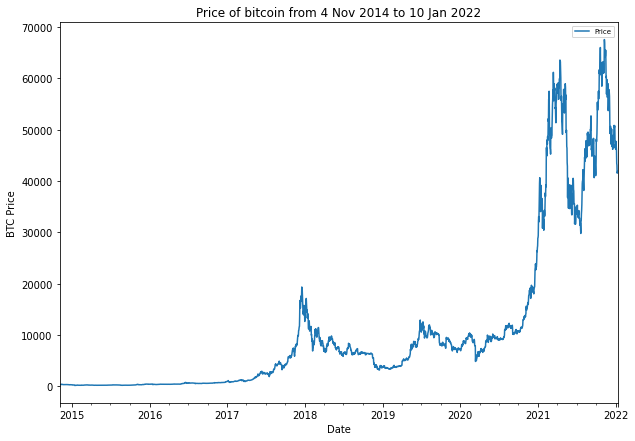

In [36]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of bitcoin from 4 Nov 2014 to 10 Jan 2022")
plt.legend(fontsize=7);

## Format data part 1: Create train and test sets of our time series data

### Creating train test splits the wrong way

In [37]:
timestamps  =bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()
timestamps[:10], prices[:10]

(array(['2014-11-04T00:00:00.000000000', '2014-11-05T00:00:00.000000000',
        '2014-11-06T00:00:00.000000000', '2014-11-07T00:00:00.000000000',
        '2014-11-08T00:00:00.000000000', '2014-11-09T00:00:00.000000000',
        '2014-11-10T00:00:00.000000000', '2014-11-11T00:00:00.000000000',
        '2014-11-12T00:00:00.000000000', '2014-11-13T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
        344.745289, 357.239982, 371.116917, 366.664633, 428.882925]))

In [38]:
# Wrong way to make train/ test sets fro rime series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timestamps, #dates
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2100,), (525,), (2100,), (525,))

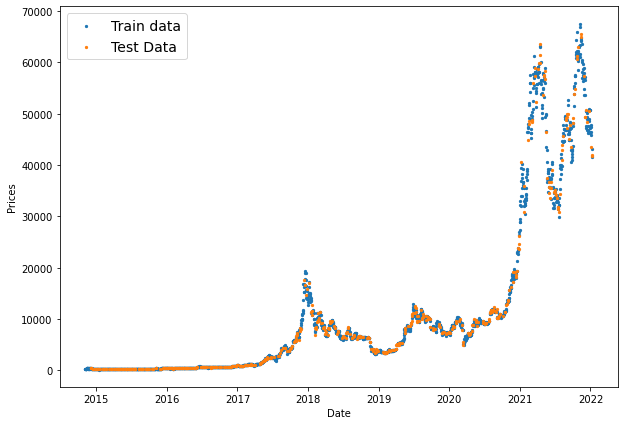

In [39]:
# Lest plot wrong train and test splits

plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train,s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test Data")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend(fontsize=14)
plt.show()

`Why wrong -- as we can see there is a data lekage in splits`

### Creating the tarin/test splits for time series the correct way


In [40]:
split_size = int(0.8 * len(prices)) # * 80% train, 20% split

# Train data splits
X_train, y_train = timestamps[:split_size], prices[:split_size]

# Test data splits
X_test, y_test = timestamps[split_size:], prices[split_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2100,), (525,), (2100,), (525,))

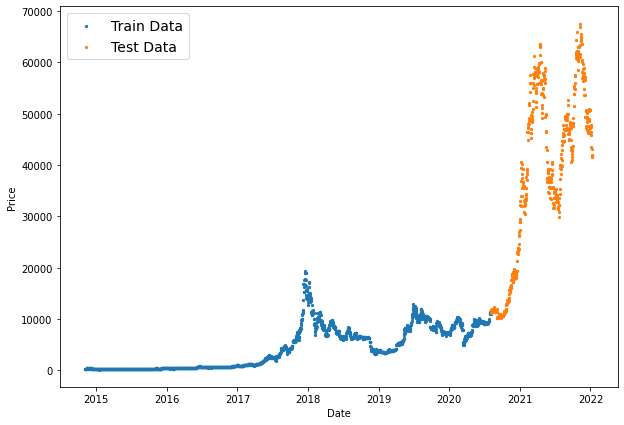

In [41]:
# Plot correctly made splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train,s=5, label="Train Data")
plt.scatter(X_test, y_test,s=5, label="Test Data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

In [42]:
def plot_time_series(timestamps, values, format=".", start=0, end=None, label=None):
  """
  Plots timestamps against values

  Parameters
  ----------
  timestamps : array of timestamp values
  values : array of values across time
  format : style of plot, default="."
  start : where to start the plot
  end : where to end the plot
  label : label to show on plot about values, default None
  """

  plt.plot(timestamps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

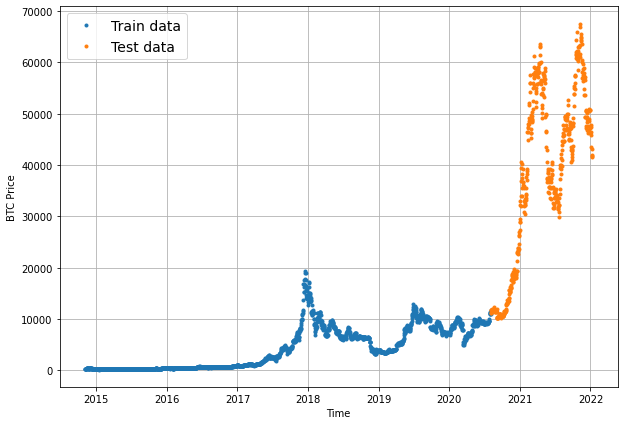

In [43]:
plt.figure(figsize=(10,7))
plot_time_series(timestamps=X_train, values=y_train, label="Train data")
plot_time_series(timestamps=X_test, values=y_test, label="Test data")

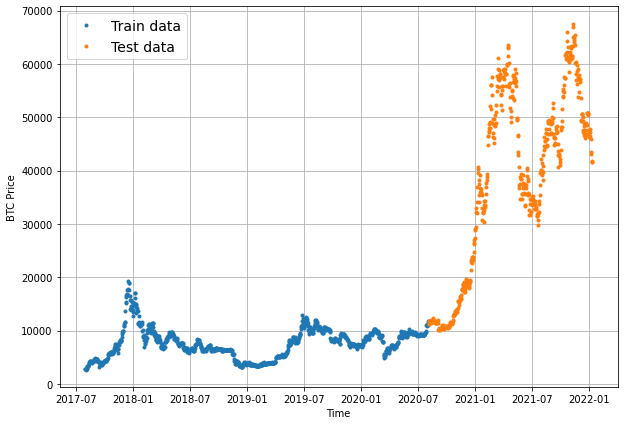

In [44]:
plt.figure(figsize=(10,7))
plot_time_series(timestamps=X_train, values=y_train, start=1000,label="Train data") # Zooming the data
plot_time_series(timestamps=X_test, values=y_test, label="Test data")

## Modelling Experiments

* Horizon = number of timestamps into the future we're going to predict
* Window Size = number od timestamps we're going to use to predict horizon

## 1 Naive Model(Baseline)

formula:

$$\hat{y}_{t} = y_{t-1}$$

> The prediction at timestep t(y-hat) is equal to the value at timestep t-1 (previous timestep) -  for horizon of 1

https://otexts.com/fpp3/simple-methods.html

In [45]:
y_test[:10]

array([11237.354858, 11194.363266, 11752.296549, 11773.533625,
       11604.023443, 11772.251532, 11688.53133 , 11895.310159,
       11391.014647, 11569.186093])

In [46]:
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([11237.354858, 11194.363266, 11752.296549, 11773.533625,
        11604.023443, 11772.251532, 11688.53133 , 11895.310159,
        11391.014647, 11569.186093]),
 array([47128.468155, 46208.210437, 47739.420026, 47317.947964,
        46434.508081, 45837.130344, 43428.699545, 43107.257821,
        41534.350712, 41687.227593]))

In [47]:
y_test[-10:]

array([46208.210437, 47739.420026, 47317.947964, 46434.508081,
       45837.130344, 43428.699545, 43107.257821, 41534.350712,
       41687.227593, 41861.803632])

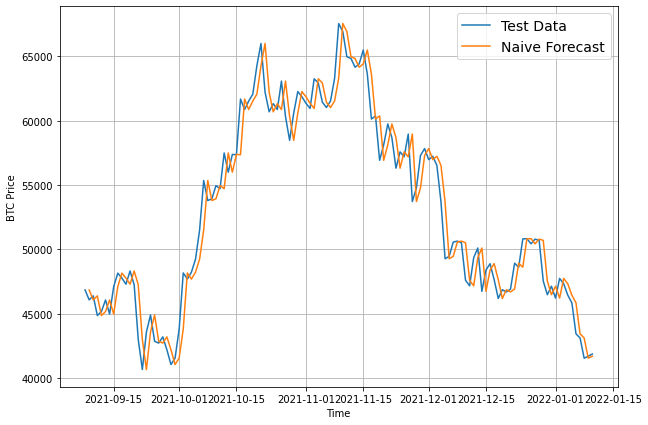

In [48]:
# Plot Naive forecast
plt.figure(figsize=(10,7))
# plot_time_series(timestamps=X_train, values=y_train, label="Train Data")
plot_time_series(timestamps=X_test, values=y_test, start=400, format="-",label="Test Data")
plot_time_series(timestamps=X_test[1:], values=naive_forecast,start=400, format="-",label="Naive Forecast")

#### Evaluating time series model 

How good our model's forecast y_pred compare aginst the actual values(y_true or ground truth values) ?

Common regression metrics:

* MAE -  mean absolute error
* MSE - mean squared error
* RMSE -  root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error


In [49]:
import tensorflow as tf

def evaluate_preds(y_true, y_pred):

  mae= tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

  return {
      "mae": mae.numpy(),
      "mse": mse.numpy(),
      "rmse": rmse.numpy(),
      "mape": mape.numpy()
  } 

In [50]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 1112.547989736641,
 'mape': 2.822934133016182,
 'mse': 2676604.3201613766,
 'rmse': 1636.0331048488526}

## Format data part 2: Windowing our dataset

We window our time series to turn data into a supervised learning problem

```
Windowing for 1 week
[0,1,2,3,4,5,6]->[7]


In [51]:
# What we want to do with our bitcoin data
print(f"We want to use: {prices[:7]} to predict: {prices[7]}")


We want to use: [324.467934 328.644408 337.921358 348.99286  341.459753 344.745289
 357.239982] to predict: 371.116917


In [52]:
# Global variables for window anfd horizon size
HORIZON  = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of bitcoin data to make teh prediction

In [53]:
# Function to label windowed data
def get_labeled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> ouput: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [54]:
test_window, test_label = get_labeled_windows(tf.expand_dims(tf.range(8), axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[7]], dtype=int32)>)

We have got a way to label our windowed data.

However, this works only for a small scale.

Now we need to do tit for entire time series

We could do this with python loops, however for large time seires, that'd be quite slow.

To speed things up, we will leverage NUmPy's indexing. https://numpy.org/doc/stable/user/basics.indexing.html

**Resource: The fucntion we are about to create has been adapted from the following article**

https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [56]:
import numpy as np

def make_windows(x, window_size=WINDOW_SIZE, horizon = HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # Create 
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T

  windowed_array = x[window_indexes]

  windows, labels = get_labeled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [62]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
full_windows[:10], full_labels[:10]

(array([[324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
         344.745289, 357.239982],
        [328.644408, 337.921358, 348.99286 , 341.459753, 344.745289,
         357.239982, 371.116917],
        [337.921358, 348.99286 , 341.459753, 344.745289, 357.239982,
         371.116917, 366.664633],
        [348.99286 , 341.459753, 344.745289, 357.239982, 371.116917,
         366.664633, 428.882925],
        [341.459753, 344.745289, 357.239982, 371.116917, 366.664633,
         428.882925, 418.944218],
        [344.745289, 357.239982, 371.116917, 366.664633, 428.882925,
         418.944218, 399.688315],
        [357.239982, 371.116917, 366.664633, 428.882925, 418.944218,
         399.688315, 374.983975],
        [371.116917, 366.664633, 428.882925, 418.944218, 399.688315,
         374.983975, 388.040069],
        [366.664633, 428.882925, 418.944218, 399.688315, 374.983975,
         388.040069, 387.062731],
        [428.882925, 418.944218, 399.688315, 374.983975, 388.040069,
    

In [63]:
prices[:10]

array([324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
       344.745289, 357.239982, 371.116917, 366.664633, 428.882925])